# Big Data with H2O - Regression

### 1. Packages and Setup 
#### Import packages and dataset

In [1]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
%matplotlib inline

#### Set up some paramaters

In [2]:
data_Path = None
model_Path = None
report_Path = None

min_mem_size = 6
run_time = 333
nthreads = 1 

name = 'Muticlass_classification'
target = None
classification = True
max_models = 9

### 2. Helper functions

In [3]:
# generate run_id
def alphabet(n):
    alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
    str=''
    r=len(alpha)-1   
    while len(str)<n:
        i=random.randint(0,r)
        str+=alpha[i]   
    return str

In [4]:
# save dictionary to json file
def dict_to_json(dct,n):
    j = json.dumps(dct, indent=4)
    f = open(n, 'w')
    print(j, file=f)
    f.close()

In [5]:
# function to set the meta_data
def set_meta_data(run_id,target,model,run_time,classification,name,nthreads,min_mem_size):
    m_data={}
    m_data['run_id'] =run_id
    m_data['start_time'] = time.time()
    m_data['target']=target
    m_data['max_models']=model
    m_data['run_time']=run_time
    m_data['classification']=classification
    m_data['project'] =name
    m_data['end_time'] = time.time()
    m_data['execution_time'] = 0.0
    m_data['nthreads'] = nthreads
    m_data['min_mem_size'] = min_mem_size
    return m_data

In [6]:
# get all variables and its tpye
def get_variables_types(df):
    '''
    param: 
    df: Dateset dataframe
    
    return:
    Dictionary of all variables and its type
    '''
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d 

In [7]:
# get the best model for different type
def stackedensemble_df(df):
    '''
    param: 
    df: AutoML leaderboard dataframe
    
    return:
    List of best models' id
    '''
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
        if len(row['model_id'])>3:
            key=row['model_id'][0:3]
        if key in bm_algo:
            if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

In [8]:
# get the best stacked_ensemble model
def get_stacked_ensemble(model_set):
    '''
    param: 
    model_set: List of all models' name
    
    return:
    Stacked ensemble model id
    '''
    se=None
    for model in model_set:
        if 'BestOfFamily' in model:
            se=model
    if se is None:     
        for model in model_set:
            if 'AllModels'in model:
                se=model           
    return se  

In [9]:
# get model and id by algo in certain model list
def get_model_by_algo(algo,models_list):
    mod=None
    mod_id=None    
    for m in models_list:
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id

In [10]:
# for 5 types model, get the statistic data
def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d

def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d

In [11]:
def predictions_test(mod,test,run_id,ifSave):
    '''
    param: 
    mod: model to be used
    test: test dataset
    run_id: running instance id
    
    return:
    the prediction
    '''
    mod_perf = mod.model_performance(test)
    if ifSave:
        stats_test = {}
        stats_test = model_performance_stats(mod_perf)
        # write performance_stats to report
        npath = os.path.join(report_Path, run_id + '_test_stats.json')
        dict_to_json(stats_test,npath)

        try:
            cf=mod_perf.confusion_matrix(metrics=["f1","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
            cf_df=cf[0].table.as_data_frame()
            cf_df.to_csv(os.path.join(report_Path, run_id + '_test_confusion_matrix.csv'))
        except:
            pass
    
    predictions = mod.predict(test)    
    if ifSave:
        # write prediction value to report
        predictions_df=test.cbind(predictions).as_data_frame()
        predictions_df.to_csv(os.path.join(report_Path, run_id + '_predictions.csv'))
    
    return predictions, mod_perf

In [12]:
def model_performance_stats(perf):
    d={}
    try:    
        d['mse']=perf.mse()
    except:
        pass      
    try:    
        d['rmse']=perf.rmse() 
    except:
        pass      
    try:    
        d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
        pass      
    try:    
        d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
        pass      
    try:    
        d['residual_deviance']=perf.residual_deviance() 
    except:
        pass      
    try:    
        d['null_deviance']=perf.null_deviance() 
    except:
        pass      
    try:    
        d['aic']=perf.aic() 
    except:
         pass      
    try:
        d['logloss']=perf.logloss() 
    except:
        pass    
    try:
        d['auc']=perf.auc()
    except:
        pass  
    try:
        d['gini']=perf.gini()
    except:
        pass    
    return d

In [13]:
# Function to plot the true/prediction value¶
def plot_result(model, pred_value, y_test):
    plt.figure()
    plt.plot(np.arange(len(pred_value)), y_test,'go-',label='true value')
    plt.plot(np.arange(len(pred_value)),pred_value,'ro-',label='predict value')
    plt.title(model)
    plt.xlabel('Record_index')
    plt.ylabel('Y_xalue')
    plt.legend()
    plt.show()

### 3. Data Overview

#### set up data path and model path

In [14]:
run_id=alphabet(9)
print (run_id)

K77qDEeCe


In [15]:
rootDir=os.path.abspath(os.curdir)
os.chdir(rootDir)

In [16]:
run_dir = os.path.join(rootDir, 'multiclass', run_id)
report_Path = os.path.join(run_dir, 'reports/')
model_Path = os.path.join(run_dir, 'models')
os.mkdir(run_dir)
os.mkdir(report_Path)
os.mkdir(model_Path)
os.chdir(run_dir)

In [17]:
# load dataset
data_Path = os.path.join(rootDir,'data_folder/processed.cleveland.data')
heart_disease = pd.read_csv(data_Path,header=None)
heart_disease.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
                         'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

In [18]:
heart_disease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


1. age: age in years  
2. sex: sex (1 = male; 0 = female)  
3. cp: chest pain type  
    -- Value 1: typical angina  
    -- Value 2: atypical angina  
    -- Value 3: non-anginal pain  
    -- Value 4: asymptomatic  
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)  
5. chol: serum cholestoral in mg/dl  
6. fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)  
7. restecg: resting electrocardiographic results
    -- Value 0: normal  
    -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)  
    -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria  
8. thalach: maximum heart rate achieved  
9. exang: exercise induced angina (1 = yes; 0 = no)  
10. oldpeak = ST depression induced by exercise relative to rest  
11. slope: the slope of the peak exercise ST segment  
    -- Value 1: upsloping  
    -- Value 2: flat  
    -- Value 3: downsloping  
12. ca: number of major vessels (0-3) colored by flourosopy  
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect  
14. num: diagnosis of heart disease (angiographic disease status)  
    -- Value 0: < 50% diameter narrowing  
    -- Value 1: > 50% diameter narrowing  
    (in any major vessel: attributes 59 through 68 are vessels)  

In [19]:
# check if there is null value in dataset
heart_disease.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

### 4. Launch H2O Instance

In [20]:
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,port=port_no)

Checking whether there is an H2O instance running at http://localhost:45549..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_144"; Java(TM) SE Runtime Environment (build 1.8.0_144-b01); Java HotSpot(TM) 64-Bit Server VM (build 25.144-b01, mixed mode)
  Starting server from /Users/lzq/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/qy/r0h6l3351xl9cvg1kl8ltwmc0000gn/T/tmpi2dlggid
  JVM stdout: /var/folders/qy/r0h6l3351xl9cvg1kl8ltwmc0000gn/T/tmpi2dlggid/h2o_lzq_started_from_python.out
  JVM stderr: /var/folders/qy/r0h6l3351xl9cvg1kl8ltwmc0000gn/T/tmpi2dlggid/h2o_lzq_started_from_python.err
  Server is running at http://127.0.0.1:45549
Connecting to H2O server at http://127.0.0.1:45549... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.7
H2O cluster version age:,1 month and 9 days
H2O cluster name:,H2O_from_python_lzq_576mim
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [21]:
# meta data
meta_data = set_meta_data(run_id,target,max_models,run_time,classification,name,nthreads,min_mem_size)
print(meta_data)

{'run_id': 'K77qDEeCe', 'start_time': 1539213787.812379, 'target': None, 'max_models': 9, 'run_time': 333, 'classification': True, 'project': 'Muticlass_classification', 'end_time': 1539213787.812384, 'execution_time': 0.0, 'nthreads': 1, 'min_mem_size': 6}


#### import dataset and do some modification

In [22]:
df = h2o.import_file(data_Path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [23]:
df.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
              'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

In [24]:
print(df.head(5))

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [25]:
print(df.describe())

Rows:303
Cols:14




,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
type,int,int,int,int,int,int,int,int,int,real,int,int,int,int
mins,29.0,0.0,1.0,94.0,126.0,0.0,0.0,71.0,0.0,0.0,1.0,0.0,3.0,0.0
mean,54.43894389438945,0.6798679867986799,3.158415841584159,131.68976897689765,246.69306930693077,0.1485148514851485,0.9900990099009903,149.6072607260726,0.32673267326732675,1.0396039603960403,1.6006600660065995,0.6722408026755854,4.7342192691029865,0.9372937293729376
maxs,77.0,1.0,4.0,200.0,564.0,1.0,2.0,202.0,1.0,6.2,3.0,3.0,7.0,4.0
sigma,9.038662442446752,0.46729882777013,0.9601256119600138,17.59974772958769,51.776917542637065,0.35619787492797644,0.9949712915251783,22.875003276980376,0.4697944645223165,1.161075022068635,0.6162261453459619,0.937438317724216,1.9397057693786433,1.2285356879701044
zeros,0,97,0,0,0,258,151,0,204,99,0,176,0,164
missing,0,0,0,0,0,0,0,0,0,0,0,4,2,0
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0


None


In [26]:
categorical_variables = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'num']

In [27]:
# convert all categorical_variables into factor
for var in categorical_variables:
    df[var] = df[var].asfactor()
y = df['num']

In [28]:
print(df.describe())

Rows:303
Cols:14




,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
type,int,enum,enum,int,int,enum,enum,int,enum,real,enum,int,enum,enum
mins,29.0,,,94.0,126.0,,,71.0,,0.0,,0.0,,
mean,54.43894389438945,,,131.68976897689765,246.69306930693077,,,149.6072607260726,,1.0396039603960403,,0.6722408026755854,,
maxs,77.0,,,200.0,564.0,,,202.0,,6.2,,3.0,,
sigma,9.038662442446752,,,17.59974772958769,51.776917542637065,,,22.875003276980376,,1.161075022068635,,0.937438317724216,,
zeros,0,,,0,0,,,0,,99,,176,,
missing,0,0,0,0,0,0,0,0,0,0,0,4,2,0
0,63.0,1,1,145.0,233.0,1,2,150.0,0,2.3,3,0.0,6,0
1,67.0,1,4,160.0,286.0,0,2,108.0,1,1.5,2,3.0,3,2
2,67.0,1,4,120.0,229.0,0,2,129.0,1,2.6,2,2.0,7,1


None


In [29]:
# specify y/target variable
y = df.columns[-1]
meta_data['target'] = y
for key, val in df.types.items():
    if key in y:
        if val in ['real','int','enum']:
            print('OK')

OK


In [30]:
# check if classification
if classification:
    df[y] = df[y].asfactor()
    print('Done')
    print(df[y].levels())
else:
    print('Regression!')

Done
[['0', '1', '2', '3', '4']]


In [31]:
# specify X variables
X = []
for i in df.columns:
    if i not in y:
        X.append(i)
print(X)

['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [32]:
# get all variables and types
allV=get_variables_types(df)
meta_data['variables']=allV
print(allV)

{'age': 'int', 'sex': 'enum', 'cp': 'enum', 'trestbps': 'int', 'chol': 'int', 'fbs': 'enum', 'restecg': 'enum', 'thalach': 'int', 'exang': 'enum', 'oldpeak': 'real', 'slope': 'enum', 'ca': 'int', 'thal': 'enum', 'num': 'enum'}


### 5. Set up AutoML

In [33]:
# Split data into train/test by 0.9¶
train, test = df.split_frame([0.9])

In [34]:
# Set up AutoML
aml = H2OAutoML(max_runtime_secs=run_time,project_name = name, nfolds=4)

In [35]:
# model start time
model_start_time = time.time()

In [36]:
# start training
aml.train(x=X,y=y,training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [37]:
# caculate model_execution_time
meta_data['model_execution_time'] = time.time() - model_start_time

In [38]:
# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()
aml_leaderboard_df

,model_id,mean_per_class_error,logloss,rmse,mse
0,DeepLearning_grid_0_AutoML_20181010_192309_mod...,0.641105,3.623004,0.621207,0.385898
1,DeepLearning_grid_0_AutoML_20181010_192309_mod...,0.660479,1.385359,0.601860,0.362236
2,DeepLearning_grid_0_AutoML_20181010_192309_mod...,0.669033,2.306984,0.627345,0.393561
3,DeepLearning_grid_0_AutoML_20181010_192309_mod...,0.674888,3.161993,0.642206,0.412429
4,DRF_0_AutoML_20181010_192309,0.680444,2.075062,0.623384,0.388608
5,GBM_grid_0_AutoML_20181010_192309_model_10,0.685694,1.171716,0.614125,0.377149
6,DeepLearning_0_AutoML_20181010_192309,0.689413,1.180113,0.621511,0.386276
7,GBM_grid_0_AutoML_20181010_192309_model_9,0.692139,1.108126,0.622315,0.387276
8,GBM_grid_0_AutoML_20181010_192309_model_28,0.694955,1.286031,0.708684,0.502234
9,DeepLearning_grid_0_AutoML_20181010_192309_mod...,0.696861,1.840578,0.629664,0.396477


### 6. Models Description

In [39]:
# Get model_set and top one model id
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])

In [40]:
mod_best

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_0_AutoML_20181010_192309_model_4


ModelMetricsMultinomial: deeplearning
** Reported on train data. **

MSE: 0.0015246638356461884
RMSE: 0.0390469439988098
LogLoss: 0.004170766908798843
Mean Per-Class Error: 0.007692307692307693
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,4,Error,Rate
118.0,0.0,0.0,0.0,0.0,0.0,0 / 118
0.0,40.0,0.0,0.0,0.0,0.0,0 / 40
0.0,0.0,28.0,0.0,0.0,0.0,0 / 28
0.0,1.0,0.0,25.0,0.0,0.0384615,1 / 26
0.0,0.0,0.0,0.0,11.0,0.0,0 / 11
118.0,41.0,28.0,25.0,11.0,0.0044843,1 / 223


Top-5 Hit Ratios: 


k,hit_ratio
1,0.9955157
2,1.0
3,1.0
4,1.0
5,1.0



ModelMetricsMultinomial: deeplearning
** Reported on validation data. **

MSE: 0.41629388858502425
RMSE: 0.6452084070941917
LogLoss: 4.913588979479945
Mean Per-Class Error: 0.6903296703296704
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,4,Error,Rate
27.0,1.0,1.0,1.0,0.0,0.1,3 / 30
7.0,1.0,1.0,2.0,2.0,0.9230769,12 / 13
1.0,2.0,4.0,0.0,0.0,0.4285714,3 / 7
0.0,1.0,4.0,0.0,0.0,1.0,5 / 5
0.0,0.0,1.0,0.0,0.0,1.0,1 / 1
35.0,5.0,11.0,3.0,2.0,0.4285714,24 / 56


Top-5 Hit Ratios: 


k,hit_ratio
1,0.5714286
2,0.7142857
3,0.8035715
4,0.9285715
5,1.0



ModelMetricsMultinomial: deeplearning
** Reported on cross-validation data. **

MSE: 0.3858975450378395
RMSE: 0.6212065236600783
LogLoss: 3.623003584054258
Mean Per-Class Error: 0.6411048273760139
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,4,Error,Rate
105.0,4.0,9.0,0.0,0.0,0.1101695,13 / 118
17.0,12.0,4.0,4.0,3.0,0.7,28 / 40
8.0,7.0,9.0,2.0,2.0,0.6785714,19 / 28
5.0,9.0,4.0,5.0,3.0,0.8076923,21 / 26
1.0,4.0,2.0,3.0,1.0,0.9090909,10 / 11
136.0,36.0,28.0,14.0,9.0,0.4080717,91 / 223


Top-5 Hit Ratios: 


k,hit_ratio
1,0.5919282
2,0.735426
3,0.8475336
4,0.9282512
5,1.0


Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid
accuracy,0.5913961,0.0534035,0.6785714,0.625,0.5892857,0.4727273
err,0.4086039,0.0534035,0.3214286,0.375,0.4107143,0.5272727
err_count,22.75,2.8449516,18.0,21.0,23.0,29.0
logloss,3.6279848,0.8583967,1.7696465,4.682969,3.320557,4.7387657
max_per_class_error,0.975,0.0306186,1.0,1.0,0.9,1.0
mean_per_class_accuracy,0.3461451,0.0798298,0.5137363,0.2661616,0.3819048,0.2227778
mean_per_class_error,0.6538549,0.0798298,0.4862637,0.7338384,0.6180952,0.7772222
mse,0.3863315,0.0462165,0.2997240,0.3720385,0.3904563,0.4831074
r2,0.7495970,0.0146904,0.7659526,0.7139709,0.7606586,0.7578058
rmse,0.6193361,0.0371102,0.5474705,0.6099495,0.624865,0.6950592


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_classification_error
,2018-10-10 19:28:00,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan
,2018-10-10 19:28:00,4 min 10.114 sec,13273 obs/sec,10.0,1,2230.0,0.5352346,1.8196551,0.8168920,0.3094170,0.6622628,2.9473939,0.6175127,0.4464286
,2018-10-10 19:28:05,4 min 15.129 sec,21964 obs/sec,510.0,51,113730.0,0.0774225,0.0197843,0.9961686,0.0089686,0.6465957,4.9549479,0.6353955,0.4285714
,2018-10-10 19:28:08,4 min 18.787 sec,22471 obs/sec,890.0,89,198470.0,0.0390469,0.0041708,0.9990255,0.0044843,0.6452084,4.9135890,0.6369584,0.4285714


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
oldpeak,1.0,1.0,0.0602728
chol,0.9922000,0.9922000,0.0598027
trestbps,0.8903198,0.8903198,0.0536621
age,0.8719403,0.8719403,0.0525543
thalach,0.8569664,0.8569664,0.0516518
---,---,---,---
restecg.missing(NA),0.0,0.0,0.0
slope.missing(NA),0.0,0.0,0.0
exang.missing(NA),0.0,0.0,0.0
fbs.missing(NA),0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [41]:
# Get stacked ensemble model
se=get_stacked_ensemble(model_set)
print(se)
mod_best_se=h2o.get_model(se)

StackedEnsemble_BestOfFamily_0_AutoML_20181010_192309


In [42]:
mod_best_se

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_0_AutoML_20181010_192309
No model summary for this model


ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.4696872294472811
RMSE: 0.6853373107071299

ModelMetricsMultinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.45649958489297726
RMSE: 0.6756475300724315

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4696872294472817
RMSE: 0.6853373107071303


In [43]:
# get the best model for different types
bm=stackedensemble_df(aml_leaderboard_df)
if se is not None:
    bm.append(se)
bm

['GBM_grid_0_AutoML_20181010_192309_model_10',
 'GLM_grid_0_AutoML_20181010_192309_model_0',
 'DRF_0_AutoML_20181010_192309',
 'XRT_0_AutoML_20181010_192309',
 'DeepLearning_grid_0_AutoML_20181010_192309_model_4',
 'StackedEnsemble_BestOfFamily_0_AutoML_20181010_192309']

In [44]:
# Best Models leaderboard
aml_leaderboard_df_best=aml_leaderboard_df.loc[aml_leaderboard_df['model_id'].isin(bm)]
aml_leaderboard_df_best

,model_id,mean_per_class_error,logloss,rmse,mse
0,DeepLearning_grid_0_AutoML_20181010_192309_mod...,0.641105,3.623004,0.621207,0.385898
4,DRF_0_AutoML_20181010_192309,0.680444,2.075062,0.623384,0.388608
5,GBM_grid_0_AutoML_20181010_192309_model_10,0.685694,1.171716,0.614125,0.377149
19,GLM_grid_0_AutoML_20181010_192309_model_0,0.719134,1.059283,0.610993,0.373312
29,XRT_0_AutoML_20181010_192309,0.742528,2.388428,0.625120,0.390775
38,StackedEnsemble_BestOfFamily_0_AutoML_20181010...,0.800000,1.304548,0.685337,0.469687


In [45]:
# save leaderboard
leaderboard_stats = os.path.join(report_Path, run_id + '_leaderboard.csv')
aml_leaderboard_df.to_csv(leaderboard_stats)

leaderboard_stats = os.path.join(report_Path, run_id + '_BestModel_leaderboard.csv')
aml_leaderboard_df_best.to_csv(leaderboard_stats)

In [46]:
# get the best model and the algo and save all into meta_data
print(mod_best._id)
print(mod_best.algo)

meta_data['mod_best']=mod_best._id
meta_data['mod_best_algo']=mod_best.algo

meta_data['models']=bm

DeepLearning_grid_0_AutoML_20181010_192309_model_4
deeplearning


In [47]:
# save all models
for mod in bm:
    try:   
        m=h2o.get_model(mod) 
        h2o.save_model(m, path = model_Path)
    except:    
        pass

### 7. Result & Prediction
#### Best Model Prediction

In [48]:
predictions_df, mod_perf = predictions_test(mod_best,test,run_id, True)
predictions_df.head(5)

deeplearning prediction progress: |███████████████████████████████████████| 100%


predict,p0,p1,p2,p3,p4
0,0.999985,1.48377e-05,5.56013e-12,2.3033e-11,1.10132e-07
0,0.687616,6.83536e-05,0.312316,6.48837e-08,4.31791e-20
0,0.999999,1.33232e-06,1.11755e-12,2.90263e-20,1.09834e-21
2,0.000385969,0.324146,0.675467,1.32314e-06,1.2144e-08
0,1,1.5592e-11,3.11623e-14,1.73713e-15,1.25182e-21


In [49]:
predictions_df.describe()

Rows:24
Cols:6




,predict,p0,p1,p2,p3,p4
type,enum,real,real,real,real,real
mins,,4.4983621314189174e-15,3.5981754960071714e-20,9.285273326926856e-31,2.3861046374024978e-35,9.51829499986522e-44
mean,,0.6800246572397989,0.08360943028718994,0.04150042182551973,0.1946597078640175,0.0002057827834738926
maxs,,1.0,0.9999999989295363,0.6754670033473898,0.9999993849462901,0.0033547573409389844
sigma,,0.4552393971281812,0.22350533668452788,0.14927634811500184,0.39052600344650434,0.0007444531550684305
zeros,,0,0,0,0,0
missing,0,0,0,0,0,0
0,0,0.9999850520973436,1.4837741823506623e-05,5.56013256044636e-12,2.3032965269205616e-11,1.1013223963098849e-07
1,0,0.6876159734750303,6.835356155834415e-05,0.3123156080796732,6.488373804995798e-08,4.317905404966581e-20
2,0,0.9999986676741558,1.332324726759318e-06,1.117553757074342e-12,2.902627905128777e-20,1.0983405883465096e-21


In [50]:
mod_perf.confusion_matrix()

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,4,Error,Rate
14.0,1.0,0.0,1.0,0.0,0.125,2 / 16
2.0,0.0,0.0,0.0,0.0,1.0,2 / 2
0.0,0.0,0.0,1.0,0.0,1.0,1 / 1
1.0,0.0,1.0,2.0,0.0,0.5,2 / 4
0.0,0.0,0.0,1.0,0.0,1.0,1 / 1
17.0,1.0,1.0,5.0,0.0,0.3333333,8 / 24


As we can see, the error rate for class 0 is 2/16, which is good. However, the error rate for rest class are very high (2/2, 1/1, 2/4, 1/1), and the overall accuracy is arround 66%. In this case, this model have very good performance for class 0, and bad performance on other class.  
  
Since this model is to determain the heart disease level for patients, we can tell that the model can make confident prediction that if the patient is in good condition or not, but can not predict the actual disease level is the patient is marked as sick.

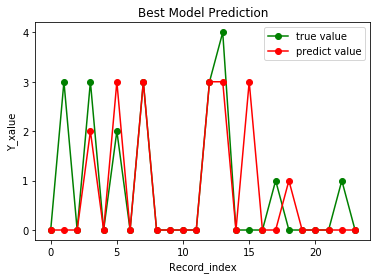

In [51]:
actual_value = [test[x, 'num'] for x in range(len(test['num']))]
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
plot_result('Best Model Prediction', pred_value, actual_value)

#### GBM

In [52]:
# get the GBM model
model_GBM, model_GBM_ID = get_model_by_algo('GBM', bm)
model_GBM_ID

'GBM_grid_0_AutoML_20181010_192309_model_10'

In [53]:
# write scoring_history, statistic data into file
if model_GBM is not None:
    try:     
        sh_df = model_GBM.scoring_history()
        sh = os.path.join(report_Path, run_id + '_gbm_scoring_history.csv')
        sh_df.to_csv(sh) 
    except:
        pass
    try:
        stats_gbm = gbm_stats(model_GBM)
        gbm_stats = os.path.join(report_Path, run_id + '_gbm_stats.json')
        dict_to_json(stats_gbm,gbm_stats)
        print(stats_gbm['varimp'])
    except:
        pass

[('oldpeak', 86.7362289428711, 1.0, 0.17824638954319527), ('thalach', 70.8223876953125, 0.8165260186946764, 0.14554281480040565), ('chol', 58.724639892578125, 0.677048571379062, 0.12068146339369613), ('ca', 56.126800537109375, 0.6470975418366107, 0.11534280051465262), ('age', 49.56549835205078, 0.5714509260564826, 0.10185906437068348), ('exang', 30.851593017578125, 0.3556944242745273, 0.06340124690757996), ('trestbps', 28.906024932861328, 0.33326356569986815, 0.059403027352292956), ('cp', 28.532447814941406, 0.32895651750935967, 0.05863531156274626), ('slope', 27.67698860168457, 0.31909375054700667, 0.05687730896080093), ('thal', 22.328947067260742, 0.2574350688219075, 0.045886871559309005), ('sex', 13.495896339416504, 0.15559699221308768, 0.02773460208576355), ('restecg', 8.922296524047852, 0.1028670099310466, 0.01833567312331307), ('fbs', 3.9188663959503174, 0.045181424690846114, 0.008053425825561098)]


In [54]:
if model_GBM is not None:
    predictions_df, mod_perf = predictions_test(model_GBM,test,run_id, False)
else:
    print('No Such Model')

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [55]:
predictions_df.head(5)

predict,p0,p1,p2,p3,p4
0,0.650166,0.238625,0.0597537,0.0295276,0.0219281
0,0.328223,0.110786,0.266871,0.254388,0.0397324
0,0.906815,0.0492229,0.020178,0.0113523,0.0124314
1,0.0305199,0.400864,0.197051,0.212129,0.159436
0,0.959997,0.0187437,0.00990694,0.00828598,0.00306605


In [56]:
predictions_df.describe()

Rows:24
Cols:6




,predict,p0,p1,p2,p3,p4
type,enum,real,real,real,real,real
mins,,0.02694597556521028,0.0024401706421889905,0.0018332426753567255,0.0016386932456797108,0.0018528633518599491
mean,,0.605813564914655,0.19806329780039886,0.09853005695960203,0.06418842224604877,0.0334046580792955
maxs,,0.9910200727665517,0.7262428440522546,0.5582854927412255,0.3355677736064635,0.20212384752618176
sigma,,0.39444668216673756,0.2325355070824913,0.15298891422489935,0.09831482687507473,0.0520418221406399
zeros,,0,0,0,0,0
missing,0,0,0,0,0,0
0,0,0.6501659574498712,0.23862466115452932,0.05975366062412243,0.02952758756323028,0.02192813320824689
1,0,0.32822263999931317,0.11078605033251196,0.26687066256262065,0.2543882502831204,0.039732396822433916
2,0,0.9068152792113064,0.04922292153274349,0.020178020886924945,0.011352334400909884,0.012431443968115291


In [57]:
mod_perf


ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.2803111687651498
RMSE: 0.5294442074148604
LogLoss: 0.8376586474396316
Mean Per-Class Error: 0.5375
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,4,Error,Rate
13.0,2.0,0.0,1.0,0.0,0.1875,3 / 16
1.0,1.0,0.0,0.0,0.0,0.5,1 / 2
0.0,0.0,1.0,0.0,0.0,0.0,0 / 1
1.0,2.0,1.0,0.0,0.0,1.0,4 / 4
0.0,1.0,0.0,0.0,0.0,1.0,1 / 1
15.0,6.0,2.0,1.0,0.0,0.375,9 / 24


Top-5 Hit Ratios: 


k,hit_ratio
1,0.625
2,0.8333333
3,0.875
4,0.9166667
5,1.0


Very similiar preformance, but a little bit lower accuracy for the overall test data

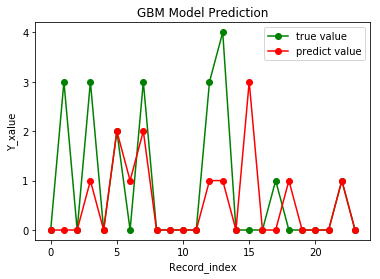

In [58]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
plot_result('GBM Model Prediction', pred_value, actual_value)

#### DeepLearning

In [59]:
# get the DeepLearning model
model_DEE, model_DEE_ID = get_model_by_algo('Dee', bm)
model_DEE_ID

'DeepLearning_grid_0_AutoML_20181010_192309_model_4'

In [60]:
# write scoring_history, statistic data, confusion_matrix into file
if model_DEE is not None:
    try:     
        sh_df = model_DEE.scoring_history()
        sh = os.path.join(report_Path, run_id + '_dl_scoring_history.csv')
        sh_df.to_csv(sh) 
    except:
        pass   
    try:
        stats_dl = dl_stats(model_DEE)
        dl_stats = os.path.join(report_Path, run_id + '_dl_stats.json')
        dict_to_json(stats_dl,dl_stats)
        print(stats_dl['varimp'])
    except:
        pass
    try:
        cf = model_DEE.confusion_matrix()    
        cf_df.to_csv(os.path.join(report_Path, run_id + '_dl_confusion_matrix.csv'))
    except:
        pass

[('oldpeak', 1.0, 1.0, 0.06027284849643422), ('chol', 0.9922000169754028, 0.9922000169754028, 0.05980272130131791), ('trestbps', 0.8903197646141052, 0.8903197646141052, 0.05366210828596694), ('age', 0.8719403147697449, 0.8719403147697449, 0.05255432649004999), ('thalach', 0.8569663763046265, 0.8569663763046265, 0.05165180456554698), ('ca', 0.8554988503456116, 0.8554988503456116, 0.051563352595754695), ('sex.0', 0.7337740659713745, 0.7337740659713745, 0.04422665310890518), ('slope.1', 0.7134498357772827, 0.7134498357772827, 0.043001653861610034), ('cp.3', 0.6966884136199951, 0.6966884136199951, 0.04199139520333906), ('thal.3', 0.6799667477607727, 0.6799667477607727, 0.04098353277039815), ('exang.0', 0.6523177027702332, 0.6523177027702332, 0.03931704607061227), ('restecg.0', 0.6284692287445068, 0.6284692287445068, 0.03787963060878852), ('exang.1', 0.6035889387130737, 0.6035889387130737, 0.03638002465717661), ('slope.2', 0.6022289395332336, 0.6022289395332336, 0.036298053632654835), ('tha

In [61]:
if model_DEE is not None:
    predictions_df, mod_perf = predictions_test(model_DEE,test,run_id, False)
else:
    print('No Such Model')

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [62]:
predictions_df.head(5)

predict,p0,p1,p2,p3,p4
0,0.999985,1.48377e-05,5.56013e-12,2.3033e-11,1.10132e-07
0,0.687616,6.83536e-05,0.312316,6.48837e-08,4.31791e-20
0,0.999999,1.33232e-06,1.11755e-12,2.90263e-20,1.09834e-21
2,0.000385969,0.324146,0.675467,1.32314e-06,1.2144e-08
0,1,1.5592e-11,3.11623e-14,1.73713e-15,1.25182e-21


In [63]:
predictions_df.describe()

Rows:24
Cols:6




,predict,p0,p1,p2,p3,p4
type,enum,real,real,real,real,real
mins,,4.4983621314189174e-15,3.5981754960071714e-20,9.285273326926856e-31,2.3861046374024978e-35,9.51829499986522e-44
mean,,0.6800246572397989,0.08360943028718994,0.04150042182551973,0.1946597078640175,0.0002057827834738926
maxs,,1.0,0.9999999989295363,0.6754670033473898,0.9999993849462901,0.0033547573409389844
sigma,,0.4552393971281812,0.22350533668452788,0.14927634811500184,0.39052600344650434,0.0007444531550684305
zeros,,0,0,0,0,0
missing,0,0,0,0,0,0
0,0,0.9999850520973436,1.4837741823506623e-05,5.56013256044636e-12,2.3032965269205616e-11,1.1013223963098849e-07
1,0,0.6876159734750303,6.835356155834415e-05,0.3123156080796732,6.488373804995798e-08,4.317905404966581e-20
2,0,0.9999986676741558,1.332324726759318e-06,1.117553757074342e-12,2.902627905128777e-20,1.0983405883465096e-21


In [64]:
mod_perf


ModelMetricsMultinomial: deeplearning
** Reported on test data. **

MSE: 0.33893245851971515
RMSE: 0.5821790605301046
LogLoss: 6.076016203134494
Mean Per-Class Error: 0.725
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,4,Error,Rate
14.0,1.0,0.0,1.0,0.0,0.125,2 / 16
2.0,0.0,0.0,0.0,0.0,1.0,2 / 2
0.0,0.0,0.0,1.0,0.0,1.0,1 / 1
1.0,0.0,1.0,2.0,0.0,0.5,2 / 4
0.0,0.0,0.0,1.0,0.0,1.0,1 / 1
17.0,1.0,1.0,5.0,0.0,0.3333333,8 / 24


Top-5 Hit Ratios: 


k,hit_ratio
1,0.6666667
2,0.7916667
3,0.875
4,0.9583333
5,1.0


This is the best model

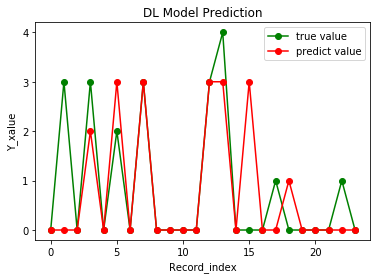

In [65]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
plot_result('DL Model Prediction', pred_value, actual_value)

#### DRF

In [66]:
# get the DRF model
model_DRF, model_DRF_ID = get_model_by_algo('DRF', bm)
model_DRF_ID

'DRF_0_AutoML_20181010_192309'

In [67]:
# write scoring_history, statistic data into file
if model_DRF is not None:
    try:     
        sh_df = model_DRF.scoring_history()
        sh = os.path.join(report_Path, run_id + '_drf_scoring_history.csv')
        sh_df.to_csv(sh) 
    except:
        pass   
    try:
        stats_drf = drf_stats(model_DRF)
        drf_stats = os.path.join(report_Path, run_id + '_drf_stats.json')
        dict_to_json(stats_drf,drf_stats)
        print(stats_drf['varimp'])
    except:
        pass

In [68]:
if model_DRF is not None:
    predictions_df, mod_perf = predictions_test(model_DRF,test,run_id, False)
else:
    print('No Such Model')

drf prediction progress: |████████████████████████████████████████████████| 100%


In [69]:
predictions_df.head(5)

predict,p0,p1,p2,p3,p4
0,0.599667,0.333148,0.0666297,0,0.000555247
0,0.363636,0.318182,0.136364,0.136364,0.0454545
0,0.732926,0,0,0.0666297,0.200444
1,0.0454545,0.318182,0.272727,0.227273,0.136364
0,0.949604,0,0.0499792,0,0.000416493


In [70]:
predictions_df.describe()

Rows:24
Cols:6




,predict,p0,p1,p2,p3,p4
type,enum,real,real,real,real,real
mins,,0.0,0.0,0.0,0.0,0.00033322227662002174
mean,,0.5950494847043365,0.18826927999402174,0.09052499804887486,0.07803194481741413,0.048124292435352815
maxs,,0.9996213555274008,0.5924097500676037,0.45,0.391304347826087,0.3333333333333333
sigma,,0.377237596255006,0.19130038441277394,0.1350158986009725,0.11028695933316941,0.08738998171362834
zeros,,2,7,12,12,0
missing,0,0,0,0,0,0
0,0,0.5996668517316629,0.333148250962035,0.06662965019240699,0.0,0.000555247113895117
1,0,0.36363636363636365,0.3181818181818182,0.13636363636363635,0.13636363636363635,0.045454545454545456
2,0,0.7329261521164769,0.0,0.0,0.06662965019240699,0.2004441976911161


In [71]:
mod_perf


ModelMetricsMultinomial: drf
** Reported on test data. **

MSE: 0.29556658968892363
RMSE: 0.5436603624404888
LogLoss: 1.0341265734689526
Mean Per-Class Error: 0.6375
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,4,Error,Rate
13.0,2.0,0.0,1.0,0.0,0.1875,3 / 16
2.0,0.0,0.0,0.0,0.0,1.0,2 / 2
0.0,0.0,1.0,0.0,0.0,0.0,0 / 1
2.0,2.0,0.0,0.0,0.0,1.0,4 / 4
0.0,1.0,0.0,0.0,0.0,1.0,1 / 1
17.0,5.0,1.0,1.0,0.0,0.4166667,10 / 24


Top-5 Hit Ratios: 


k,hit_ratio
1,0.5833333
2,0.7916666
3,0.8333333
4,0.875
5,1.0


Similiar as privious model

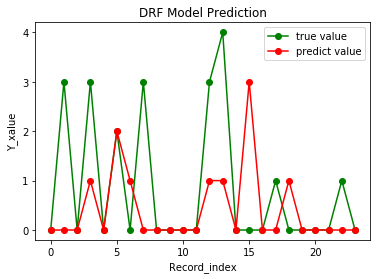

In [72]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
plot_result('DRF Model Prediction', pred_value, actual_value)

#### XRT

In [73]:
# get the XRT model
model_XRT, model_XRT_ID = get_model_by_algo('XRT', bm)
model_XRT_ID

'XRT_0_AutoML_20181010_192309'

In [74]:
# write scoring_history, statistic data into file
if model_XRT is not None:
    try:     
        sh_df = model_XRT.scoring_history()
        sh = os.path.join(report_Path, run_id + '_xrt_scoring_history.csv')
        sh_df.to_csv(sh) 
    except:
        pass   
    try:
        stats_xrt = xrt_stats(model_XRT)
        xrt_stats = os.path.join(report_Path, run_id + '_xrt_stats.json')
        dict_to_json(stats_xrt,xrt_stats)
        print(stats_xrt['varimp'])
    except:
        pass

In [75]:
if model_XRT is not None:
    predictions_df, mod_perf = predictions_test(model_XRT,test,run_id, False)
else:
    print('No Such Model')

drf prediction progress: |████████████████████████████████████████████████| 100%


In [76]:
predictions_df.head(5)

predict,p0,p1,p2,p3,p4
0,0.569853,0.170956,0.259191,0,0
0,0.435115,0.183206,0.183206,0.183206,0.0152672
0,0.837161,0.0542797,0,0,0.108559
2,0,0.214286,0.571429,0.190476,0.0238095
0,0.935614,0,0.0643863,0,0


In [77]:
predictions_df.describe()

Rows:24
Cols:6




,predict,p0,p1,p2,p3,p4
type,enum,real,real,real,real,real
mins,,0.0,0.0,0.0,0.0,0.0
mean,,0.6336183926081775,0.16129587871175932,0.1113205705166767,0.06740066354155344,0.026364494621832987
maxs,,0.9982110912875654,0.5502336449710935,0.5714285702121501,0.3764705882352941,0.19917012438280943
sigma,,0.3503339516243574,0.14684156026875889,0.16844487761327598,0.09766773188798401,0.05627595099592409
zeros,,2,6,3,11,17
missing,0,0,0,0,0,0
0,0,0.5698529419538148,0.17095588207665618,0.25919117596952906,0.0,0.0
1,0,0.435114503618818,0.18320610678687071,0.18320610678687071,0.18320610678687071,0.015267176020569848
2,0,0.837160751606288,0.05427974946457067,0.0,0.0,0.10855949892914134


In [78]:
mod_perf


ModelMetricsMultinomial: drf
** Reported on test data. **

MSE: 0.28588382896297965
RMSE: 0.5346810534916865
LogLoss: 2.091087273451841
Mean Per-Class Error: 0.625
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,4,Error,Rate
14.0,1.0,0.0,1.0,0.0,0.125,2 / 16
2.0,0.0,0.0,0.0,0.0,1.0,2 / 2
0.0,0.0,1.0,0.0,0.0,0.0,0 / 1
1.0,1.0,2.0,0.0,0.0,1.0,4 / 4
1.0,0.0,0.0,0.0,0.0,1.0,1 / 1
18.0,2.0,3.0,1.0,0.0,0.375,9 / 24


Top-5 Hit Ratios: 


k,hit_ratio
1,0.625
2,0.7916667
3,0.8333334
4,0.9166667
5,1.0


Relative same performance as other model according to the error rate and accuracy

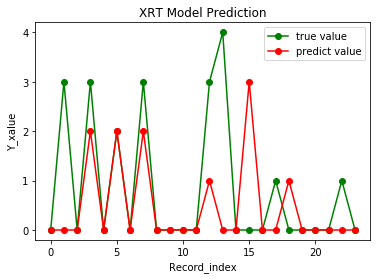

In [79]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
plot_result('XRT Model Prediction', pred_value, actual_value)

#### GLM

In [80]:
# get the XRT model
model_GLM, model_GLM_ID = get_model_by_algo('GLM', bm)
model_GLM_ID

'GLM_grid_0_AutoML_20181010_192309_model_0'

In [81]:
# write scoring_history, statistic data into file
if model_GLM is not None:
    try:     
        sh_df = model_GLM.scoring_history()
        sh = os.path.join(report_Path, run_id + '_glm_scoring_history.csv')
        sh_df.to_csv(sh) 
    except:
        pass   
    try:
        stats_glm = glm_stats(model_GLM)
        glm_stats = os.path.join(report_Path, run_id + '_glm_stats.json')
        dict_to_json(stats_glm,glm_stats)
        print(stats_glm['varimp'])
    except:
        pass

In [82]:
if model_GLM is not None:
    predictions_df, mod_perf = predictions_test(model_GLM,test,run_id, False)
else:
    print('No Such Model')

glm prediction progress: |████████████████████████████████████████████████| 100%


In [83]:
predictions_df.head(5)

predict,p0,p1,p2,p3,p4
0,0.605019,0.221935,0.0750693,0.0659984,0.0319782
0,0.26912,0.217926,0.150105,0.226325,0.136524
0,0.717441,0.165679,0.0589977,0.0370397,0.0208423
1,0.0684436,0.365777,0.345626,0.156013,0.0641405
0,0.860331,0.0555131,0.0328952,0.0393465,0.0119138


In [84]:
predictions_df.describe()

Rows:24
Cols:6




,predict,p0,p1,p2,p3,p4
type,enum,real,real,real,real,real
mins,,0.02272311729475261,0.04104358467046511,0.010261132602029656,0.006452002636534683,0.0024427061755594045
mean,,0.6042461641861127,0.1741890425601516,0.10464029662918886,0.08174104850652436,0.03518344811802251
maxs,,0.9354908488385294,0.5646337715156838,0.4118409668394064,0.31169753253119253,0.17256947152829025
sigma,,0.33551877763606053,0.12532316548448735,0.12424314736535642,0.10175545378962664,0.045609426620151806
zeros,,0,0,0,0,0
missing,0,0,0,0,0,0
0,0,0.6050186449310526,0.22193533518939743,0.07506933952148971,0.06599844759085698,0.03197823276720309
1,0,0.26911998518364494,0.21792579194354458,0.15010487729395688,0.22632523953830622,0.13652410604054727
2,0,0.7174411119955708,0.16567921716523332,0.05899768799859267,0.037039691608744006,0.020842291231859312


In [85]:
mod_perf


ModelMetricsMultinomialGLM: glm
** Reported on test data. **

MSE: 0.2789507023421634
RMSE: 0.5281578384746016


Very good MSE/RMSE because there isn't much class

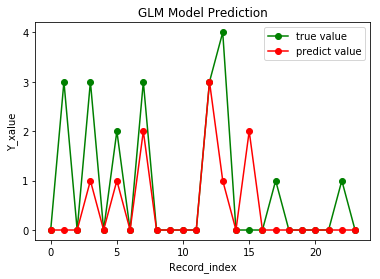

In [86]:
pred_value = [predictions_df[x,0] for x in range(len(predictions_df[0]))]
plot_result('GLM Model Prediction', pred_value, actual_value)

### 8. Clean up

#### Update and save meta data

In [87]:
meta_data['end_time'] = time.time()
meta_data['execution_time'] = meta_data['end_time'] - meta_data['start_time']
  
meta_data_path = os.path.join(run_dir, run_id + '_meta_data.json')
dict_to_json(meta_data, meta_data_path)

#### shutdown

In [88]:
os.chdir(rootDir)
h2o.cluster().shutdown()

H2O session _sid_958d closed.
